# Build an LSTM model to predict the future values with historical inputs.

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("Datasets/R1_Personal_Hygiene_Daily_Time_Span.csv")



In [2]:
N = 35
df_train = df.iloc[:N,:]
df_test = df.iloc[N:,:]


In [3]:
def load_data(train_set, label, num_dimensions, input_window_size=21, output_window_size=7):
    """
    Generate the x_train, y_train and x_test in prediction using LSTM model.
    :param train_set:
        x_train data original inputs.
    :param label:
        y_train data original inputs.
    :param num_dimensions:
        Input data number of dimensions.
    :param input_window_size:
        For example, when this is set to 250, we use the past data of 250 days to forecast future.
    :param output_window_size:
        The number of data to forecast the future.
    :return x_train, y_train, x_test
    """

    train_set_len = len(train_set)

    x_train = []
    y_train = []

    for i in range(input_window_size, train_set_len-output_window_size + 1):
        x_train.append(train_set[i - input_window_size:i, :])
        y_train.append(label[i:i + output_window_size])

    x_train = np.array(x_train, dtype=float)
    y_train = np.array(y_train, dtype=float)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], num_dimensions))

    x_test = []
    x_test.append(train_set[train_set_len-input_window_size: , :])
    x_test = np.array(x_test, dtype=float)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], num_dimensions))
    return x_train, y_train, x_test

In [4]:
from sklearn.preprocessing import StandardScaler
def Data_Standard(input):
    """
    Normalize the input data.
    :param input:
    :return input_std:
        normalized data.
    """
    std_scaler = StandardScaler()
    input_std = std_scaler.fit_transform(np.array(input).reshape(-1,1))
    return input_std

In [5]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow import keras
def train_LSTM_without_Aux(x_train, y_train):
    """
    Train an LSTM model with input dataset dimension (250, 2).
    :param x_train
    :param y_train
    :return model:
        Trained model.
    """
    download_dir="models/"
    file_name = "LSTMWithoutAux"
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    path = os.path.join(download_dir, file_name)
    if not os.path.exists(path):
        num_attr = 1 # one dimension for input data
        output_size = 7 # Output 1 data points
        model = Sequential()
        model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], num_attr)))
        model.add(LSTM(64,return_sequences=False))
        model.add(Dense(64))
        model.add(Dense(output_size))

        model.compile(optimizer="adam", loss="mean_squared_error", metrics="mape")
        # callback = keras.callbacks.EarlyStopping(monitor='loss', patience=20)
        model.fit(x_train, y_train, batch_size=32, epochs=2000)#, callbacks=[callback])

        # Save the trained model

        model.save(path)
        print("The model is saved with ", str(path))
        return model
    else:
        print("The model is already saved as ", str(path))
        model = keras.models.load_model(path)

        return model

In [6]:
def get_model_predictions(model, x_train, x_test, input_dimension, y_train_mean, y_train_std):
    """
    Get the predicted close prices in the training and testing processes of the model.
    :param model:
    :param x_train:
        x_train when training the model.
    :param x_test:
        x_test generated to test the model.
    :param input_dimension:
        Dimensions of input x.
    :param y_train_mean:
        Mean value of y_train.
    :param y_train_std:
        Standard deviation of y_train.
    :return train_predictions:
        predicted prices in training.
    :return test_predictions:
        predicted prices in testing.
    :return predictions_total:
        Reverse normalization and concatenation of train_predictions and test_predictions.
    """
    train_predictions = []
    input_window_lenth = 21
    # Start appending the predicted prices in training process
    for item in x_train:
        item = np.reshape(item, (1, input_window_lenth, input_dimension))
        predicted_close_price = model.predict(item)
        train_predictions.append(predicted_close_price[0, 0])

    # Append last 20 predicted close prices in the training process.
    train_predictions = train_predictions[:-1]
    predicted_close_price = model.predict(x_train[-1].reshape(1, input_window_lenth, input_dimension))
    for i in range(len(predicted_close_price[0])):
        train_predictions.append(predicted_close_price[0, i])

    #------------------------------------------------------
    test_predictions = model.predict(x_test)
    test_predictions = test_predictions.reshape(-1)

    # Concat the train predictions and test predictions
    predictions_total = [*train_predictions,  *test_predictions]

    # Reverse normalization
    predictions_total = (np.array(predictions_total) * y_train_std) + y_train_mean

    return train_predictions, test_predictions, predictions_total

In [7]:
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def plot_model_prediction(predictions_total, df_train, df_test, df_total, file_name):
    plt.figure(figsize=(16,7))
    # plt.ylim((30,170))
    plt.xticks(rotation=90)

    # Real y values
    plt_y_1 = df_train['R1_Personal_Hygiene_time_span'].values.tolist()+df_test['R1_Personal_Hygiene_time_span'].values.tolist()

    # Real training ys + predicted ys.
    plt_y_2 = df_train.loc[:20]['R1_Personal_Hygiene_time_span'].tolist()  + predictions_total.tolist()

    plt.plot_date(df_total["start_time"], plt_y_2,'-', color='red', label='Predicted time span',linewidth=1)
    plt.plot_date(df_total["start_time"], plt_y_1,'-', color = 'blue', label = 'Real time span',linewidth=1)
    plt.axvline(dt.date(2009, 3, 26), linewidth=0.2, color = 'purple')
    plt.title('R1 Personal Hygiene Duration Prediction')
    plt.xlabel('Date')
    plt.ylabel('Duration Time (sec)')
    plt.legend()
    plt.tight_layout()


    download_dir="images/"
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    path = os.path.join(download_dir, file_name)
    if not os.path.exists(path):
        plt.savefig(path)
        print("The figure is saved with ", str(path))
        return
    print("The figure is already saved as ", str(path))
    return

The model is already saved as  models/LSTMWithoutAux


2022-04-25 06:13:09.008031: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-25 06:13:13.509028: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Predictions of R1 personal hygiene time span: 

[ 917.28827 -269.10138  924.8705  2808.4785  -821.99506  864.5149
 2425.5054 ]


ConversionError: Failed to convert value(s) to axis units: datetime.date(2009, 3, 26)

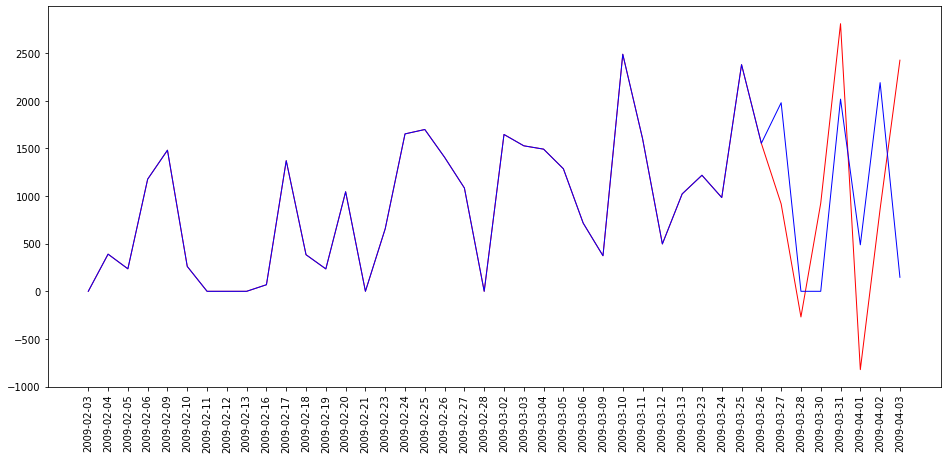

In [8]:
# plt.style.use("fivethirtyeight")

# Acquire the mean and standard of y_train
y_train_mean = np.mean(df_train["R1_Personal_Hygiene_time_span"])
y_train_std = np.std(df_train["R1_Personal_Hygiene_time_span"])
# y_train needs to be normalized as label in training the model.
y_train_normal = (df_train["R1_Personal_Hygiene_time_span"] - y_train_mean)/y_train_std
y_test = df_test["R1_Personal_Hygiene_time_span"].values

#(1) model without auxiliary data
X = df_train["R1_Personal_Hygiene_time_span"].values
X_std = Data_Standard(X)

x_train,y_train, x_test = load_data(train_set=X_std, label=y_train_normal, num_dimensions=1)
model_without_Aux = train_LSTM_without_Aux(x_train, y_train)

train_predictions, test_predictions, totla_predictions = get_model_predictions(model_without_Aux, x_train, x_test, 1, y_train_mean, y_train_std)

print("Predictions of R1 personal hygiene time span: \n")
print(((test_predictions * y_train_std) + y_train_mean))

plot_model_prediction(totla_predictions, df_train, df_test,df, "Prediction_R1_Hygiene_Duration.pdf")

MSE = mean_squared_error(df_test["R1_Personal_Hygiene_time_span"].values, ((test_predictions * y_train_std) + y_train_mean))
RMSE = mean_squared_error(df_test["R1_Personal_Hygiene_time_span"].values, ((test_predictions * y_train_std) + y_train_mean), squared=False)
MAE = mean_absolute_error(df_test["R1_Personal_Hygiene_time_span"].values, ((test_predictions * y_train_std) + y_train_mean))
MAPE = mean_absolute_percentage_error(df_test["R1_Personal_Hygiene_time_span"].values, ((test_predictions * y_train_std) + y_train_mean))

print("MSE in task without auxiliary data: ", MSE)
print("RMSE in task without auxiliary data: ", RMSE)
print("MAE in task without auxiliary data: ", MAE)
print("MAPE in task without auxiliary data: ", MAPE)


'''
# Plot joint plots.
d = {'yhat':((test_predictions * y_train_std) + y_train_mean), 'y':AAPL_df_test['close'].values}

df_for_joint_plot_without_Aux_test = pd.DataFrame(data=d, dtype=float)
create_joint_plot(df_for_joint_plot_without_Aux_test, title='Test set', file_name="JointPlotWithoutAuxTest.pdf", limit_min=120, limit_max=150)

# Plot residual distribution
df_yhat = (test_predictions * y_train_std) + y_train_mean
df_y = AAPL_df_test['close'].values

df_residual = df_yhat-df_y
plot_residual(df_residual, "ResidualPlotWithoutAuxTest.pdf", title="Residual Distribution test set")
'''